In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('air_quality_health_impact_data.csv')

In [4]:
selected_columns = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']
new_df = df[selected_columns]

In [5]:
health_columns = ['RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions'] 

In [6]:
# Extract features and labels
X_pollution = new_df.values
X_health = df[health_columns].values
y_score = df['HealthImpactScore'].values
y_binary = df['HealthImpactClass'].values

In [16]:
class AdvancedHealthImpactScoreModel:
    def __init__(self, pollution_feature_dim, health_feature_dim):
        """
        Initialize Advanced Health Impact Score Model
        
        Args:
            pollution_feature_dim (int): Number of pollution features
            health_feature_dim (int): Number of health impact features
        """
        self.pollution_feature_dim = pollution_feature_dim
        self.health_feature_dim = health_feature_dim
        
        # Scalers
        self.pollution_scaler = StandardScaler()
        self.health_scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Build model components
        self.model = self._build_multi_output_model()
        self._create_fuzzy_inference_system()
    
    def _create_fuzzy_inference_system(self):
        """
        Create advanced fuzzy logic inference system for health impact
        """
        # Fuzzy Input Variables
        self.pollution_risk = ctrl.Antecedent(np.linspace(0, 100, 100), 'pollution_risk')
        self.health_impact_score = ctrl.Antecedent(np.linspace(0, 100, 100), 'health_impact_score')
        
        # Fuzzy Output Variable
        self.health_hazard = ctrl.Consequent(np.linspace(0, 100, 100), 'health_hazard')
        
        # Membership Functions for Pollution Risk
        self.pollution_risk['low'] = fuzz.trimf(self.pollution_risk.universe, [0, 0, 30])
        self.pollution_risk['medium'] = fuzz.trimf(self.pollution_risk.universe, [20, 50, 80])
        self.pollution_risk['high'] = fuzz.trimf(self.pollution_risk.universe, [70, 100, 100])
        
        # Membership Functions for Health Impact Score
        self.health_impact_score['low'] = fuzz.trimf(self.health_impact_score.universe, [0, 0, 30])
        self.health_impact_score['medium'] = fuzz.trimf(self.health_impact_score.universe, [20, 50, 80])
        self.health_impact_score['high'] = fuzz.trimf(self.health_impact_score.universe, [70, 100, 100])
        
        # Membership Functions for Health Hazard
        self.health_hazard['safe'] = fuzz.trimf(self.health_hazard.universe, [0, 0, 30])
        self.health_hazard['moderate'] = fuzz.trimf(self.health_hazard.universe, [20, 50, 80])
        self.health_hazard['critical'] = fuzz.trimf(self.health_hazard.universe, [70, 100, 100])
        
        # Fuzzy Rules
        rules = [
            ctrl.Rule(
                self.pollution_risk['low'] & self.health_impact_score['low'], 
                self.health_hazard['safe']
            ),
            ctrl.Rule(
                self.pollution_risk['medium'] | self.health_impact_score['medium'], 
                self.health_hazard['moderate']
            ),
            ctrl.Rule(
                self.pollution_risk['high'] | self.health_impact_score['high'], 
                self.health_hazard['critical']
            )
        ]
        
        # Create Fuzzy Control System
        self.health_hazard_ctrl = ctrl.ControlSystem(rules)
        self.health_hazard_simulation = ctrl.ControlSystemSimulation(self.health_hazard_ctrl)
    
    def _build_multi_output_model(self):
        """
        Build neural network with multiple outputs
        """
        # Pollution Inputs
        pollution_inputs = Input(shape=(self.pollution_feature_dim,), name='pollution_inputs')
        
        # Health Impact Inputs
        health_inputs = Input(shape=(self.health_feature_dim,), name='health_inputs')
        
        # Feature Processing
        x_pollution = Dense(64, activation='relu')(pollution_inputs)
        x_pollution = Dropout(0.3)(x_pollution)
        
        x_health = Dense(32, activation='relu')(health_inputs)
        x_health = Dropout(0.2)(x_health)
        
        # Concatenate Features
        combined = Concatenate()([x_pollution, x_health])
        
        # Advanced Hidden Layers
        x = Dense(64, activation='relu')(combined)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        # Multiple Outputs
        # Binary Classification Output
        binary_classification = Dense(1, activation='sigmoid', name='binary_health_class')(x)
        
        # Continuous Health Impact Score Regression Output
        health_impact_score = Dense(1, activation='linear', name='health_impact_score')(x)
        
        # Uncertainty Estimation
        uncertainty = Lambda(
            lambda tensor: tf.math.reduce_std(tensor, axis=-1), 
            name='uncertainty'
        )(x)
        
        # Create Model
        model = Model(
            inputs=[pollution_inputs, health_inputs], 
            outputs=[binary_classification, health_impact_score, uncertainty]
        )
        
        # Compile Model with Multiple Losses
        model.compile(
            optimizer='adam',
            loss={
                'binary_health_class': 'binary_crossentropy',
                'health_impact_score': 'mean_squared_error',
                'uncertainty': 'mean_squared_error'
            },
            loss_weights={
                'binary_health_class': 1.0,
                'health_impact_score': 0.5,
                'uncertainty': 0.1
            },
            metrics={
                'binary_health_class': ['accuracy']
            }
        )
        
        return model
    
    def train(self, X_pollution, X_health, y_binary, y_score, epochs=130):
        """
        Train the multi-output health impact model
        
        Args:
            X_pollution (np.ndarray): Pollution features
            X_health (np.ndarray): Health impact features
            y_binary (np.ndarray): Binary health class
            y_score (np.ndarray): Continuous health impact score
            epochs (int): Number of training epochs
        """
        # Scale inputs
        X_pollution_scaled = self.pollution_scaler.fit_transform(X_pollution)
        X_health_scaled = self.health_scaler.fit_transform(X_health)
        
        # Simulate uncertainty
        uncertainty = np.random.random(len(y_binary))
        
        # Train model
        history = self.model.fit(
            [X_pollution_scaled, X_health_scaled], 
            {
                'binary_health_class': y_binary,
                'health_impact_score': y_score,
                'uncertainty': uncertainty
            },
            epochs=epochs,
            validation_split=0.2,
            verbose=1
        )
        
        return history
    
    def evaluate(self, X_pollution, X_health, y_binary, y_score):
        """
        Evaluate model performance
        
        Args:
            X_pollution (np.ndarray): Test pollution features
            X_health (np.ndarray): Test health impact features
            y_binary (np.ndarray): True binary health class
            y_score (np.ndarray): True health impact score
        """
        # Scale inputs
        X_pollution_scaled = self.pollution_scaler.transform(X_pollution)
        X_health_scaled = self.health_scaler.transform(X_health)
        
        # Predict
        y_pred_binary, y_pred_score, uncertainty = self.model.predict(
            [X_pollution_scaled, X_health_scaled]
        )
        
        # Binary Classification Evaluation
        y_pred_binary_class = (y_pred_binary > 0.5).astype(int)
        print("\nBinary Classification Report:")
        print(classification_report(y_binary, y_pred_binary_class))
        
        # Confusion Matrix
        cm = confusion_matrix(y_binary, y_pred_binary_class)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Regression Evaluation
        mse = mean_squared_error(y_score, y_pred_score)
        print("\nHealth Impact Score Regression:")
        print(f"Mean Squared Error: {mse}")
        
        # Scatter plot of true vs predicted scores
        plt.figure(figsize=(10, 6))
        plt.scatter(y_score, y_pred_score)
        plt.plot([y_score.min(), y_score.max()], [y_score.min(), y_score.max()], 'r--', lw=2)
        plt.title('True vs Predicted Health Impact Scores')
        plt.xlabel('True Scores')
        plt.ylabel('Predicted Scores')
        plt.show()
    
    def predict_health_impact(self, X_pollution, X_health):
        """
        Predict health impact with fuzzy uncertainty interpretation
        
        Args:
            X_pollution (np.ndarray): Pollution features
            X_health (np.ndarray): Health impact features
        
        Returns:
            dict: Prediction results with fuzzy interpretation
        """
        # Scale inputs
        X_pollution_scaled = self.pollution_scaler.transform(X_pollution)
        X_health_scaled = self.health_scaler.transform(X_health)
        
        # Predict
        binary_class, health_score, uncertainty = self.model.predict(
            [X_pollution_scaled, X_health_scaled]
        )
        
        # Fuzzy Uncertainty Interpretation
        self.health_hazard_simulation.input['pollution_risk'] = X_pollution_scaled[0][0] * 100
        self.health_hazard_simulation.input['health_impact_score'] = health_score[0][0] * 100
        self.health_hazard_simulation.compute()
        
        return {
            'binary_health_class': binary_class[0][0],
            'health_impact_score': health_score[0][0],
            'uncertainty': uncertainty[0],
            'fuzzy_health_hazard': self.health_hazard_simulation.output['health_hazard']
        }

In [17]:
# Split data
X_pollution_train, X_pollution_test, \
X_health_train, X_health_test, \
y_binary_train, y_binary_test, \
y_score_train, y_score_test = train_test_split(
    X_pollution, X_health, y_binary, y_score, 
    test_size=0.2
)

In [18]:
# Initialize and train model
model = AdvancedHealthImpactScoreModel(
    pollution_feature_dim=6, 
    health_feature_dim=3
)

In [19]:
# Train model
history = model.train(
    X_pollution_train, 
    X_health_train, 
    y_binary_train, 
    y_score_train
)

Epoch 1/130
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_health_class_accuracy: 0.6808 - loss: 3849.5498 - val_binary_health_class_accuracy: 0.8301 - val_loss: 142.9934
Epoch 2/130
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_health_class_accuracy: 0.6340 - loss: 313.5824 - val_binary_health_class_accuracy: 0.8301 - val_loss: 116.5059
Epoch 3/130
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_health_class_accuracy: 0.6561 - loss: 271.4195 - val_binary_health_class_accuracy: 0.8301 - val_loss: 99.7510
Epoch 4/130
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_health_class_accuracy: 0.6231 - loss: 239.4111 - val_binary_health_class_accuracy: 0.8301 - val_loss: 89.1656
Epoch 5/130
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_health_class_accuracy: 0.6451 - loss: 228.0867 - val_binary_health_class_accuracy: 0.8301 - val_loss: 84.9483
Epoch 6/130
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_health_class_accuracy: 0.6464 - loss: 222.9559 - val_binary_health_class_ac

In [20]:
prediction = model.predict_health_impact(
    X_pollution_test, 
    X_health_test
)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
x['newcolumn'] = 

In [21]:
print(prediction)

{'binary_health_class': 0.060345143, 'health_impact_score': 98.21917, 'uncertainty': 2.0954297, 'fuzzy_health_hazard': 70.33374302993168}


In [24]:
print(y_binary_test)


[0. 0. 0. ... 0. 0. 0.]


In [25]:
print(y_score_test)

[100. 100. 100. ... 100. 100. 100.]


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Binary Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       986
         1.0       0.48      0.93      0.63       101
         2.0       0.00      0.00      0.00        48
         3.0       0.00      0.00      0.00        14
         4.0       0.00      0.00      0.00        14

    accuracy                           0.88      1163
   macro avg       0.29      0.37      0.32      1163
weighted avg       0.86      0.88      0.86      1163



c:\drive\software\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\drive\software\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\drive\software\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


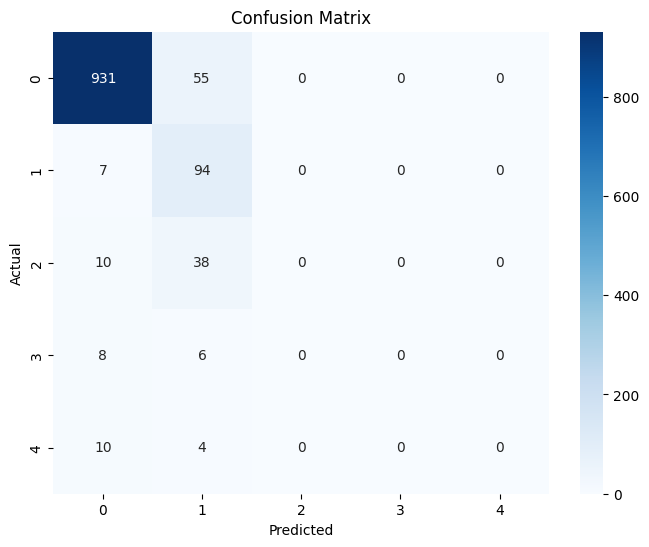


Health Impact Score Regression:
Mean Squared Error: 8.455967017448883


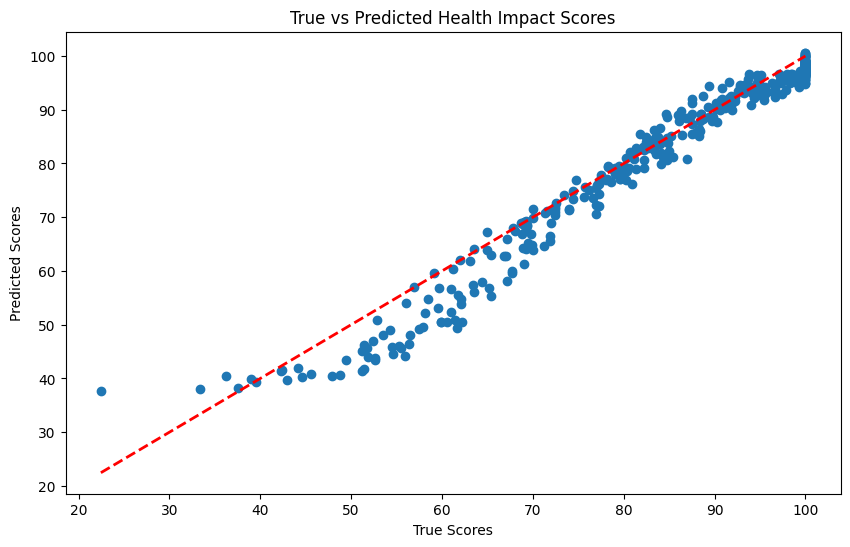

In [26]:
# Evaluate model
model.evaluate(
    X_pollution_test, 
    X_health_test, 
    y_binary_test, 
    y_score_test
)